In [49]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from numpy.polynomial.legendre import legval
from scipy.special import comb
from scipy.special import gamma

class SinActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        activation = SinActivation()
        #activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x


In [50]:
def simpsons_rule(f, x):
    # Compute the integral of f(x) using Simpson's rule
    N = x.size(0) - 1
    h = (x[-1] - x[0]) / N
    integral = h / 3 * (f[0] + f[-1] + 4 * f[1::2].sum() + 2 * f[2:-1:2].sum())
    return integral

def grunwald_letnikov_derivative(f,x, alpha, h, N):
    """
    Compute the Grünwald-Letnikov fractional derivative of order alpha.

    Parameters:
    - f: tensor, function values at discrete points.
    - alpha: float, order of the derivative (can be any real number).
    - h: float, step size.
    - N: int, number of terms in the approximation.

    Returns:
    - derivative: tensor, fractional derivative values.
    """

    order = int(alpha)
    f = derivation(f,x,order,N)
    alpha -= order
    
    derivative = torch.zeros_like(f)
    for n in range(N):
        coeff = (-1)**n * comb(alpha, n)
        if n == 0:
            shifted = f.clone()
        else:
            shifted = torch.zeros_like(f)
            shifted[n:] = f[:-n]
        derivative += coeff * shifted
        error = torch.mean((derivative)**2)
    derivative /= h**alpha
    return derivative , error

def caputo_derivative_pytorch(f , x, alpha, h):
    """
    Compute the Caputo fractional derivative of a function f using PyTorch.
    
    Parameters:
    - f: torch.Tensor, function values at discrete points (size: [N,])
    - alpha: float, order of the fractional derivative (0 < alpha < 1 for simplicity)
    - h: float, spatial step size
    
    Returns:
    - derivative: torch.Tensor, Caputo fractional derivative at each point (size: [N,])
    """

    intergration_term = 1
    
    derivative = 1/(gamma(1-alpha)) * simpsons_rule(intergration_term, torch.arange(0, f.size(0)).float())
    return derivative

def derivation(u , x ,  order = 2 , N = 50 ):

    int_order = int(order)
    alpha = order - int_order
    h = x[1] - x[0]

    for _ in range(int_order):
        u = torch.autograd.grad(u.sum(),x,create_graph=True , retain_graph= True , allow_unused= True)[0]

    if alpha > 0:
        u , error = grunwald_letnikov_derivative(u,x,alpha,h,N)
        #u = caputo_derivative_pytorch(u, alpha, h)
    return u

In [34]:



u_exact = lambda x :  0.1*torch.sin(torch.pi*x*4) + torch.tanh(5*x)
f = lambda x : (torch.pi)**2 * torch.sin(torch.pi * x) 
f= lambda x: -(-1.6 * (torch.pi**2) * torch.sin(torch.pi * x * 4) - 50 * torch.tanh(5 * x) * (1 - torch.tanh(5 * x)**2))

operator = lambda u,x :  -derivation(u , x , order=2)

# Using Legendre polynomials as test functions
def P_k(x, k):
    # Generate Legendre polynomial P_k(x)
    coeffs = [0] * (k + 1)
    coeffs[-1] = 1
    Pk = legval(x, coeffs)
    return Pk

def v(x, k):
    P_k_plus = P_k(x, k + 1)
    P_k_minus = P_k(x, k - 1)
    v_k = P_k_plus - P_k_minus
    return v_k

def simpsons_rule(f, x):
    # Compute the integral of f(x) using Simpson's rule
    N = x.size(0) - 1
    h = (x[-1] - x[0]) / N
    integral = h / 3 * (f[0] + f[-1] + 4 * f[1::2].sum() + 2 * f[2:-1:2].sum())
    return integral


num_epochs = 1
a, b = -1.0, 1.0  # Domain boundaries
N = 100            # Number of intervals (must be even for Simpson's rule)
degree = 8     # Degree of Legendre polynomials

# Define boundary conditions
x_boundary = torch.tensor([[-1.0], [1.0]], requires_grad=False)
u_boundary_exact = torch.tensor([-1.0, 1.0])
model = Net(1,1,100,3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    
    # Generate equally spaced points for Simpson's rule
    x = torch.linspace(a, b, N + 1).unsqueeze(1)  # Shape: [N+1, 1]
    x.requires_grad = True

    # Compute the function values at the interior points
    u = model(x)

    d2u = operator(u,x)
    du = derivation(u,x,order=1)

    source_f = f(x)

    #variational_term1 = sum([torch.abs( v(x ,k).T @ (d2u - source_f))**2 for k in range(1,degree+1)])/degree
    variational_term1 = sum([simpsons_rule(((d2u - source_f) * v(x,k))**2, x.squeeze()) for k in range(1,degree+1) ])/degree
    #variational_term1 = sum([simpsons_rule(((d2u - source_f) * v(x,k))**2, x.squeeze())/simpsons_rule(torch.abs(v(x,k)), x.squeeze()) for k in range(1,degree+1) ])/degree     #       sum([simpsons_rule(torch.abs((d2u - source_f)), x.squeeze())*simpsons_rule(torch.abs(v(x,k)), x.squeeze()) for k in range(1,degree+1) ])/degree
    
    
    # Compute the boundary loss
    """
    the boundary is calculated directly from the exact solution
    """
    boundary_loss = (torch.abs(u[0] - u_boundary_exact[0])**2 + torch.abs(u[-1] - u_boundary_exact[1])**2)/2


    # Compute the energy loss
    variational_term = variational_term1 #+ variational_term2 + variational_term3
    loss = variational_term + 10*boundary_loss 
    
    
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Logging every 500 epochs
    if epoch % 500 == 0 or epoch == 1:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f} , variational_term : {variational_term.item()} , boundary_loss : {boundary_loss.item()}')




Epoch 1, Loss: 220.659286 , variational_term : 212.40235900878906 , boundary_loss : 0.8256927728652954


tensor(1.1179e-07, grad_fn=<MseLossBackward0>)


Text(0.5, 0, 'x')

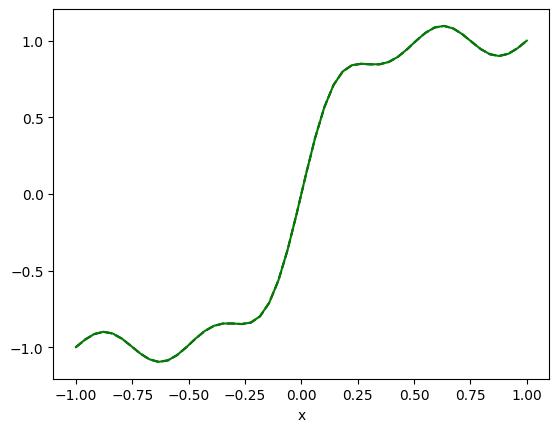

In [9]:
x_test = torch.linspace(a, b, 50).unsqueeze(1)
u_test = model(x_test)
u_exact_test = u_exact(x_test)
print(F.mse_loss(u_test, u_exact_test))
import matplotlib.pyplot as plt
plt.plot(x_test.detach().numpy(), u_test.detach().numpy(), label='Approximation' , color = 'black' ,linestyle = '--')
plt.plot(x_test.detach().numpy(), u_exact_test.detach().numpy(), label='Exact' , color = 'green')
plt.xlabel('x')

In [ ]:
u_exact = lambda x, y: torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
operator = lambda u,x,y : derivation(u , x , order=2) + derivation(u , y , order=2)

x = torch.linspace(a, b, 50)
y = torch.linspace(a, b, 50)
x, y = torch.meshgrid(x, y)
x = x.unsqueeze(-1)
y = y.unsqueeze(-1)
x.requires_grad = True
y.requires_grad = True

u = u_exact(x, y)
f = operator(u, x, y)

u_bounda = u[:, 0]
u_boundb = u[:, -1]
u_boundc = u[0, :]
u_boundd = u[-1, :]

model = Net(2, 1, 100, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    
    u_pred = model(torch.cat([x, y], dim=-1))
    d2u = operator(u_pred, x, y)
    u_bounda_pred = u_pred[:, 0]
    u_boundb_pred = u_pred[:, -1]
    u_boundc_pred = u_pred[0, :]
    u_boundd_pred = u_pred[-1, :]

    variational_term1 = sum([simpsons_rule(((d2u - f) * v(x, k) * v(y, k))**2, x.squeeze()) for k in range(1, degree + 1) ]) / degree
    variational_term2 = sum([simpsons_rule((variational_term1)**2, y.squeeze()) for k in range(1, degree + 1) ]) / degree

    loss_variational = variational_term1 + variational_term2
    
    loss = loss_variational[0][0] + F.mse_loss(u_bounda_pred, u_bounda) + F.mse_loss(u_boundb_pred, u_boundb) + F.mse_loss(u_boundc_pred, u_boundc) + F.mse_loss(u_boundd_pred, u_boundd)
    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 500 == 0 or epoch == 1:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

Epoch 1, Loss: 2653.514160
Epoch 500, Loss: 0.258216


0.003294015


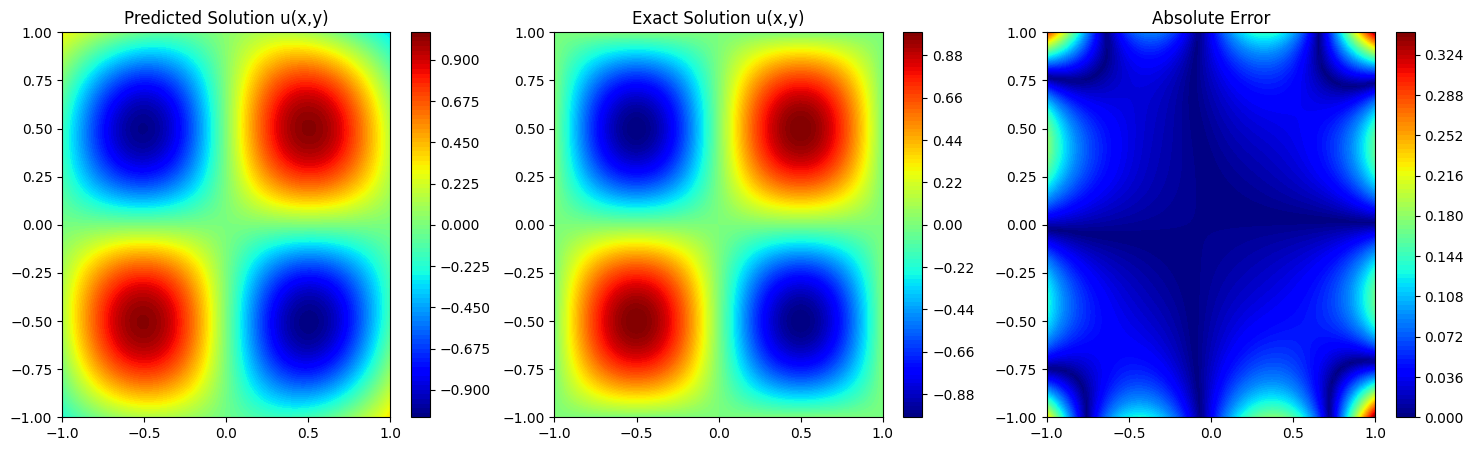

In [54]:
# Evaluate the model on a grid
x_eval = torch.linspace(a, b, 100)
y_eval = torch.linspace(a, b, 100)
X_eval, Y_eval = torch.meshgrid(x_eval, y_eval)
X_eval_flat = X_eval.reshape(-1, 1)
Y_eval_flat = Y_eval.reshape(-1, 1)
coords_eval = torch.cat((X_eval_flat, Y_eval_flat), dim=1)
u_pred = model(coords_eval).detach().numpy().reshape(100, 100)
u_exact_eval = u_exact(coords_eval[:,0], coords_eval[:,1]).numpy().reshape(100, 100)


print(np.mean((u_pred- u_exact_eval)**2))

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.contourf(X_eval, Y_eval, u_pred, levels=100, cmap='jet')
plt.colorbar()
plt.title('Predicted Solution u(x,y)')

plt.subplot(1,3,2)
plt.contourf(X_eval, Y_eval, u_exact_eval, levels=100, cmap='jet')
plt.colorbar()
plt.title('Exact Solution u(x,y)')

plt.subplot(1,3,3)
plt.contourf(X_eval, Y_eval, np.abs(u_pred - u_exact_eval), levels=100, cmap='jet')
plt.colorbar()
plt.title('Absolute Error')

plt.show()

C:\Users\mohammed\AppData\Local\Temp\ipykernel_15184\1581354691.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_k = torch.tensor(v_kx * v_ky, dtype=torch.float32).to(x.device)


Epoch 1, Loss: 16776.410156, Variational Term: 16743.353516, Boundary Loss: 3.305686
Epoch 500, Loss: 4751.672363, Variational Term: 4744.863770, Boundary Loss: 0.680860
Epoch 1000, Loss: 38.714890, Variational Term: 29.016476, Boundary Loss: 0.969842
Epoch 1500, Loss: 10.929707, Variational Term: 6.659674, Boundary Loss: 0.427003
Epoch 2000, Loss: 12.113768, Variational Term: 9.369737, Boundary Loss: 0.274403


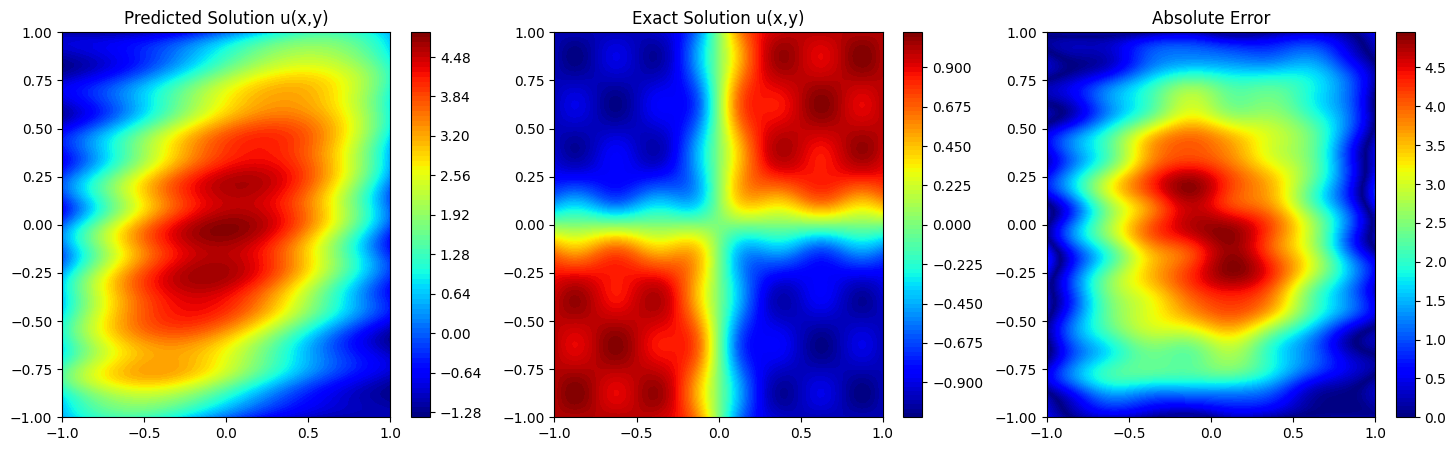

In [ ]:

# Exact solution
u_exact = lambda x, y: 0.1 * torch.sin(torch.pi * x * 4) * torch.sin(torch.pi * y * 4) + torch.tanh(5 * x) * torch.tanh(5 * y)

# Source term
def f(x, y):
    pi = torch.pi
    term1 = -1.6 * (pi ** 2) * torch.sin(pi * x * 4) * torch.sin(pi * y * 4)
    tanh_x = torch.tanh(5 * x)
    tanh_y = torch.tanh(5 * y)
    sech2_x = 1 - tanh_x ** 2
    sech2_y = 1 - tanh_y ** 2
    term2 = -50 * tanh_x * sech2_x * tanh_y * sech2_y
    return -(term1 + term2)

# PDE operator (Laplacian)
def operator(u, x):
    u_xx = derivation(u, x, order=2)
    u_yy = derivation(u, x, order=2)
    return -(u_xx + u_yy)

# Using Legendre polynomials as test functions in 2D
def P_k(x, k):
    # Generate Legendre polynomial P_k(x)
    coeffs = [0] * (k + 1)
    coeffs[-1] = 1
    Pk = legval(x, coeffs)
    return Pk

def v(x, y, kx, ky):
    P_kx_plus = P_k(x, kx + 1)
    P_kx_minus = P_k(x, kx - 1)
    P_ky_plus = P_k(y, ky + 1)
    P_ky_minus = P_k(y, ky - 1)
    v_kx = P_kx_plus - P_kx_minus
    v_ky = P_ky_plus - P_ky_minus
    v_k = torch.tensor(v_kx * v_ky, dtype=torch.float32).to(x.device)
    return v_k

# Simpson's rule for 2D integration
def simpsons_rule_2d(f, x, y):
    N_x = x.size(0) - 1
    N_y = y.size(0) - 1
    h_x = (x[-1] - x[0]) / N_x
    h_y = (y[-1] - y[0]) / N_y
    
    # Reshape f to [N_x+1, N_y+1]
    f = f.view(N_x + 1, N_y + 1)
    
    # Simpson's coefficients
    coef_x = torch.ones(N_x + 1)
    coef_x[1:-1:2] = 4
    coef_x[2:-1:2] = 2
    coef_y = torch.ones(N_y + 1)
    coef_y[1:-1:2] = 4
    coef_y[2:-1:2] = 2
    
    coef = torch.outer(coef_x, coef_y)
    
    integral = h_x * h_y / 9 * torch.sum(coef * f)
    return integral

# Training parameters
num_epochs = 2000
a, b = -1.0, 1.0  # Domain boundaries for x and y
N = 50            # Number of intervals in each dimension (must be even for Simpson's rule)
degree = 4        # Degree of Legendre polynomials

# Define boundary conditions (assumed Dirichlet boundary conditions)
x_boundary = torch.linspace(a, b, N + 1)
y_boundary = torch.linspace(a, b, N + 1)
X_boundary, Y_boundary = torch.meshgrid(x_boundary, y_boundary)
X_boundary = X_boundary.reshape(-1, 1)
Y_boundary = Y_boundary.reshape(-1, 1)
boundary_coords = torch.cat((X_boundary, Y_boundary), dim=1)
u_boundary_exact = u_exact(boundary_coords[:,0], boundary_coords[:,1])


model = Net(2, 1, 100, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    
    # Generate equally spaced points for Simpson's rule in 2D
    x = torch.linspace(a, b, N + 1)
    y = torch.linspace(a, b, N + 1)
    X, Y = torch.meshgrid(x, y)

    u_exact_eval = u_exact(X, Y)
    X = X.unsqueeze(-1)
    Y = Y.unsqueeze(-1)
    coords = torch.cat((X, Y), dim=-1)
    coords.requires_grad = True

    u = model(coords)
    u = u.squeeze()

    source_f = f(coords[:,0], coords[:,1])

    # Compute operator
    op = operator(u, coords)

    # Variational loss
    variational_terms = []
    for kx in range(1, degree + 1):
        for ky in range(1, degree + 1):
            vk = v(coords[:,0], coords[:,1], kx, ky)
            integrand = ((op - source_f) * vk) ** 2
            integral = simpsons_rule(simpsons_rule(integrand, x),y)
            variational_terms.append(integral)
    variational_term = sum(variational_terms[0]) / (degree ** 2)


    
    # Compute boundary loss
    u_boundary_1 = u[0, :]
    u_boundary_2 = u[-1, :]
    u_boundary_3 = u[:, 0]
    u_boundary_4 = u[:, -1]
    boundary_loss = torch.mean((u_boundary_1 -u_exact_eval[0, :])**2) + torch.mean((u_boundary_2 - u_exact_eval[-1, :])**2) + torch.mean((u_boundary_3 - u_exact_eval[:, 0])**2) + torch.mean((u_boundary_4 - u_exact_eval[:, -1])**2)
    
    # Total loss
    loss = variational_term + 10 * boundary_loss
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Logging every 500 epochs
    if epoch % 500 == 0 or epoch == 1:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}, Variational Term: {variational_term.item():.6f}, Boundary Loss: {boundary_loss.item():.6f}')

# Evaluate the model on a grid
x_eval = torch.linspace(a, b, 100)
y_eval = torch.linspace(a, b, 100)
X_eval, Y_eval = torch.meshgrid(x_eval, y_eval)
X_eval_flat = X_eval.reshape(-1, 1)
Y_eval_flat = Y_eval.reshape(-1, 1)
coords_eval = torch.cat((X_eval_flat, Y_eval_flat), dim=1)
u_pred = model(coords_eval).detach().numpy().reshape(100, 100)
u_exact_eval = u_exact(coords_eval[:,0], coords_eval[:,1]).numpy().reshape(100, 100)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.contourf(X_eval, Y_eval, u_pred, levels=100, cmap='jet')
plt.colorbar()
plt.title('Predicted Solution u(x,y)')

plt.subplot(1,3,2)
plt.contourf(X_eval, Y_eval, u_exact_eval, levels=100, cmap='jet')
plt.colorbar()
plt.title('Exact Solution u(x,y)')

plt.subplot(1,3,3)
plt.contourf(X_eval, Y_eval, np.abs(u_pred - u_exact_eval), levels=100, cmap='jet')
plt.colorbar()
plt.title('Absolute Error')

plt.show()


## PINO

In [52]:
class Trunk(nn.Module):
    def __init__(self, N_input , N_output , N_Hidden , N_layers):
        super(Trunk,self).__init__()
        activation = SinActivation()
        #activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x
    
class encode(nn.Module):
    def __init__(self):
        super(encode,self).__init__()

        self.f1 = nn.Sequential(*[nn.Linear(1 ,50) , nn.Tanh()])
        self.f2 = nn.Sequential(*[nn.Linear(50 , 100), nn.Tanh()])
        self.f3 = nn.Sequential(*[nn.Linear(100,50) , nn.Tanh()])
        self.f4 = nn.Sequential(*[nn.Linear(50,1)])

    def forward(self , x) :
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        x = self.f4(x)
        return x
    
class decode(nn.Module):
    def __init__(self):
        super(decode,self).__init__()

        self.f1 = nn.Sequential(*[nn.Linear(1 ,50) , nn.Tanh()])
        self.f2 = nn.Sequential(*[nn.Linear(50 , 100), nn.Tanh()])
        self.f3 = nn.Sequential(*[nn.Linear(100,50) , nn.Tanh()])
        self.f4 = nn.Sequential(*[nn.Linear(50,1)])

    def forward(self , x) :
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        x = self.f4(x)
        return x

    

class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        #activation = SinActivation()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x

class PINO(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(PINO,self).__init__()
        activation = nn.Tanh()
        self.brunch = Net(N_input ,N_output , N_Hidden ,N_layers)
        self.normeliaze = nn.LayerNorm(N_output)

        self.trunk = Trunk(1 , N_output , N_Hidden , N_layers)
        self.encode = encode()
        self.decode = decode()
    def forward(self , x , f) : 

        
        #f = lambda x: -(-1.6 * (torch.pi**2) * torch.sin(torch.pi * x * 4) - 50 * torch.tanh(5 * x) * (1 - torch.tanh(5 * x)**2))
        #f = self.trunk(f)
        #x = f(x)
        x = self.encode(x)
        x = self.brunch(x)
        
        
        
        return x
    
    def dcoder(self , x):
        return self.decode(x)

class Model(nn.Module):
    def __init__(self, N ,N_input ,N_output , N_Hidden ,N_layers):
        super(Model,self).__init__()
        self.N = N
        self.sin = SinActivation()
        self.tanh = nn.Tanh()
        self.trunk = Trunk(1 , N_output , N_Hidden , N_layers)
        self.models = []
        self.optimizers = []
        for _ in range(N):
            model = Net(N_input ,N_output , N_Hidden ,N_layers)
            optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
            self.models.append(model)
            self.optimizers.append(optimizer)
        self.flayer = Net(N_input ,N_output , N_Hidden ,N_layers)
    def forward(self, x, f):
        lenght_x = x.size(0) // self.N
        xs_small = [x[i*lenght_x:(i+1)*lenght_x] for i in range(self.N)]
        for i in range(self.N):
            xs_small[i] = self.models[i](xs_small[i])
        x = torch.cat(xs_small, dim=0)
        x = self.flayer(x)
        f = self.trunk(f)
        x = self.sin(x) * f

        return x
    
    def training_step(self, x, model, optimizer):
        optimizer.zero_grad()
        loss = model(x)
        loss.backward()
        optimizer.step()
        return loss
        
    




In [89]:
x = torch.linspace(-1 , 1, 100 , requires_grad = True).unsqueeze(1)
f = lambda x : (torch.pi)**2 * torch.sin(torch.pi * x) 
#f = lambda x : 16*torch.pi**2 * torch.sin(4*torch.pi * x)
f= lambda x: -(-1.6 * (torch.pi**2) * torch.sin(torch.pi * x * 4) - 50 * torch.tanh(5 * x) * (1 - torch.tanh(5 * x)**2))
u_exact2 = lambda x :  0.1*torch.sin(torch.pi*x*4) + torch.tanh(5*x)
u_ex = u_exact2(x)
u_boundary_exact = torch.tensor([-1.0, 1.0])
f_exact = f(x)
# 2nd order derivative
operator = lambda u,x :  -derivation(u , x ,order=2)                        
#model
model = PINO(1,1,100,1)
#optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


for ep in range(1501):
    optimizer.zero_grad()
    u = model(x,f_exact)
    f_pred = operator(u,x)
    boundary_loss = ((torch.abs(u[0] + 1)**2) + torch.abs(u[-1] - u_boundary_exact[-1])**2)/2
    loss = boundary_loss + F.mse_loss(f_pred,f_exact)
    loss.backward(retain_graph=True)
    optimizer.step()
    if ep % 500 == 0:
        print(loss.item() , boundary_loss.item())

250.2939453125 0.9862074851989746
0.21718603372573853 0.002435152418911457
0.8633842468261719 0.00011331353016430512
0.02379516325891018 4.739927680930123e-05


tensor(4.0870e-05, grad_fn=<MseLossBackward0>)


Text(0.5, 0, 'x')

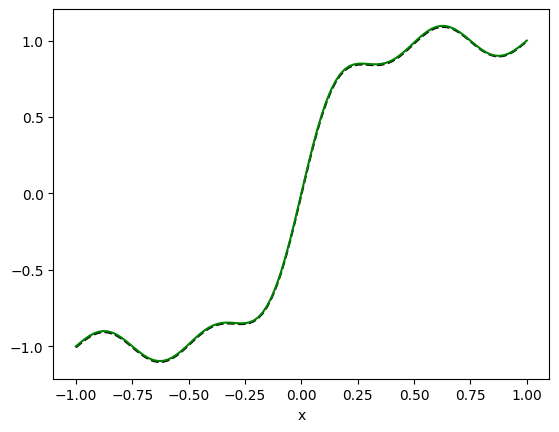

In [90]:
import matplotlib.pyplot as plt
u_test = model(x,f_exact)
u_exact_test = u_exact2(x)
print(F.mse_loss(u_test, u_exact_test))

plt.plot(x.detach().numpy().squeeze(), u_test.detach().numpy().squeeze(), label='Approximation' , color = 'black' ,linestyle = '--')
plt.plot(x.detach().numpy().squeeze(), u_exact_test.detach().numpy().squeeze(), label='Exact' , color = 'green')
plt.xlabel('x')

In [47]:
import torch

# Domaine 1D
x = torch.linspace(0, 1, 100).unsqueeze(1)  # Points dans [0, 1]
x.requires_grad = True

# Générer des données pour plusieurs paramètres p
parameters = torch.linspace(1, 10, 10)  # Valeurs de p
print(parameters.shape)
solutions = []
for p in parameters:
    f = -(torch.pi**2) * p**2 * torch.sin(p *torch.pi* x)
    u_exact = -torch.sin(p *torch.pi* x)  # Solution analytique
    solutions.append((f, u_exact, p))

train_data = solutions[:8]  # Entraîner sur 8 instances
test_data = solutions[8:]   # Tester sur des paramètres non vus


class Trunk(torch.nn.Module):
    def __init__(self):
        super(Trunk, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50)  # Fonctions de base
        )

    def forward(self, x):
        return self.net(x)

class Branch(torch.nn.Module):
    def __init__(self):
        super(Branch, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50)  # Coefficients
        )

    def forward(self, p):
        return self.net(p)

class PINO(torch.nn.Module):
    def __init__(self):
        super(PINO, self).__init__()
        self.trunk = Trunk()
        self.branch = Branch()

    def forward(self, x, p):
        basis = self.trunk(x)  # Fonctions de base
        coefficients = self.branch(p)  # Coefficients
        #print(basis.shape, coefficients.shape)
        return torch.sum(basis * coefficients, dim=-1).unsqueeze(-1)

# Fonction de perte
def pino_loss(model, x, p, f , u_exact):
    u_pred = model(x, p)
    u_xx = derivation(u_pred, x, order=2)
    pde_residual = u_xx + f
    boundary_loss = (u_pred[0]**2 + u_pred[-1]**2)  # u(0) = u(1) = 0
    return    F.mse_loss(pde_residual, torch.zeros_like(pde_residual)) + 10 * boundary_loss 


model = PINO()

model(x, parameters[0].unsqueeze(0)).shape



torch.Size([10])


torch.Size([100, 1])

In [1]:
# Entraîner PINO sur plusieurs paramètres
model_pino = PINO()
optimizer = torch.optim.Adam(model_pino.parameters(), lr=0.001)

for epoch in range(3001):
    total_loss = 0
    for f, u_exact, p in train_data:
        optimizer.zero_grad()
        loss = pino_loss(model_pino, x, p.unsqueeze(0), f , u_exact)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / len(train_data)}")

# Tester sur un paramètre non vu
f_test, u_exact_test, p_test = test_data[0]
u_pino = model_pino(x, p_test.unsqueeze(0)).detach()


NameError: name 'PINO' is not defined

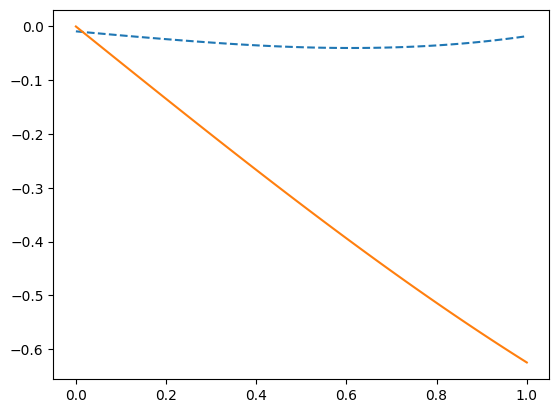

In [412]:
plt.plot(x.detach().numpy(), u_pino.numpy(), label='PINO', linestyle='--')
plt.plot(x.detach().numpy(), u_exact_test.detach().numpy(), label='Exact')

In [413]:
train_function = []
train_solution = []
exact_solution = []

for f, u_exact, p in train_data:
    u_pino = model_pino(x, p.unsqueeze(0)).detach()
    exact_solution.append(u_exact)
    train_solution.append(u_pino)
    train_function.append(f)

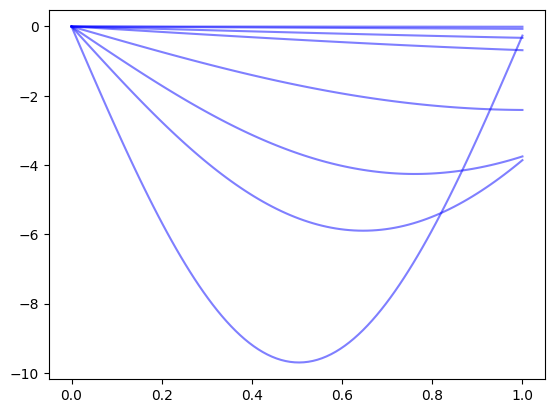

In [414]:
for f in train_function:
    plt.plot(x.detach().numpy(), f.detach().numpy(), color='blue', alpha=0.5)

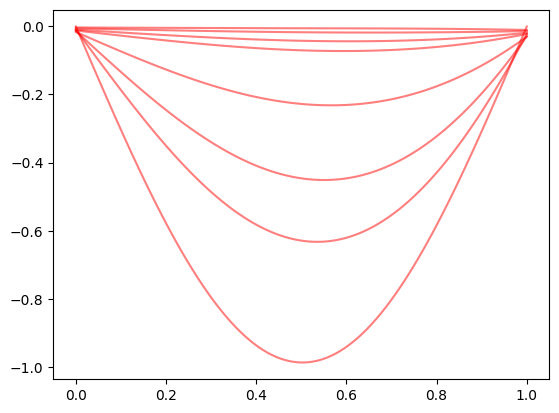

In [415]:
for u in train_solution:
    plt.plot(x.detach().numpy(), u.numpy(), color='red', alpha=0.5)

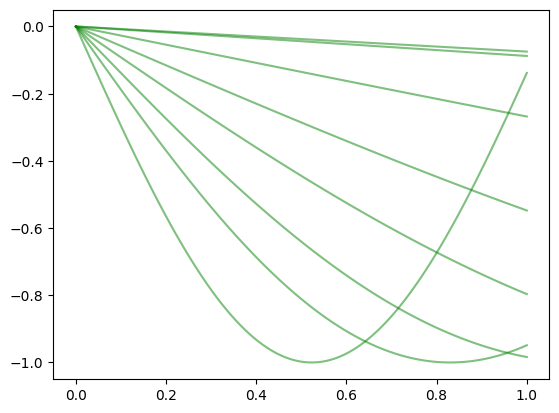

In [409]:
for u in exact_solution:
    plt.plot(x.detach().numpy(), u.detach().numpy(), color='green', alpha=0.5)

## Fractional PINNs

In [615]:
import numpy as np



# Example usage
x = torch.linspace(0, 10, 1001)
h = x[1] - x[0]
x.requires_grad = True
f = torch.sin(x)

alpha = 2.5
N = 50

df_gl , ValueError = grunwald_letnikov_derivative(f,x, alpha, h, N)
df_auto = derivation(f, x, order=alpha )
df_exact = -torch.sin(x)



error_gl = torch.mean((df_gl[2:] - df_exact[2:])**2)
error_auto = torch.mean((df_auto - df_exact)**2)
print(error_gl, error_auto , ValueError)

tensor(38.7020, grad_fn=<MeanBackward0>) tensor(38.6247, grad_fn=<MeanBackward0>) tensor(0.4768, grad_fn=<MeanBackward0>)


In [ ]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)
        
        # Xavier Initialization
        for layer in self.layers:
            nn.init.xavier_normal_(layer.weight.data, gain=1.0)
            nn.init.zeros_(layer.bias.data)
    
    def forward(self, x):
        out = x
        for i in range(len(self.layers) -1):
            out = self.activation(self.layers[i](out))
        out = self.layers[-1](out)
        return out
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def loss_function(model, x_colloc, x_bc, u_bc, f, alpha, dx):
    # Collocation points
    x_colloc = x_colloc.requires_grad_(True).to(device)
    u_pred = model(x_colloc)
    h = x_colloc[1] - x_colloc[0]
    
    # Compute fractional derivative
    frac_derivative =  derivation(u_pred , x_colloc , alpha) #grunwald_letnikov_derivative(u_pred,alpha,h, N=50)
    
    # PDE residual
    residual = frac_derivative[1:] - f(x_colloc)[1:]
    mse_pde = torch.mean(residual**2)
    
    
    mse_bc = torch.mean((u_pred[0])**2) + torch.mean((u_pred[-1])**2)
    
    return mse_pde + mse_bc


In [58]:
# Define the source term f(x)
def f(x):
    return torch.sin(torch.pi * x)

# Analytical solution for comparison (if available)
def analytical_solution(x):
    # Placeholder: Analytical solutions for fractional Poisson equations are non-trivial
    # For demonstration, we'll assume u(x) = sin(pi x)
    return torch.sin(torch.pi * x)



# Parameters
alpha = 1.5  # Order of fractional derivative
layers = [1, 20, 20, 1]  # Neural network architecture
learning_rate = 0.01
epochs = 5000

f = lambda x : derivation(analytical_solution(x), x , alpha) #grunwald_letnikov_derivative(analytical_solution(x),alpha,h, N=50)
# Instantiate the model
model = PINN(layers).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Spatial domain
x_min, x_max = 0.0, 1.0
N_colloc = 100  # Number of collocation points
N_bc = 2        # Number of boundary points

# Generate collocation points
x_colloc = torch.linspace(x_min, x_max, N_colloc).view(-1,1).to(device)

# Boundary points
x_bc = torch.tensor([[x_min], [x_max]], device=device)
u_bc = torch.tensor([[0.0], [0.0]], device=device)  # Assuming u(0)=u(1)=0

# Spatial step size
dx = (x_max - x_min) / (N_colloc -1)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x_colloc, x_bc, u_bc, f, alpha, dx)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")


Epoch 500/5000, Loss: 0.005558
Epoch 1000/5000, Loss: 0.003326
Epoch 1500/5000, Loss: 0.075812
Epoch 2000/5000, Loss: 0.000756
Epoch 2500/5000, Loss: 0.002592
Epoch 3000/5000, Loss: 0.000273
Epoch 3500/5000, Loss: 0.000224
Epoch 4000/5000, Loss: 0.000179
Epoch 4500/5000, Loss: 0.000134
Epoch 5000/5000, Loss: 0.000835


Text(0, 0.5, 'u(x)')

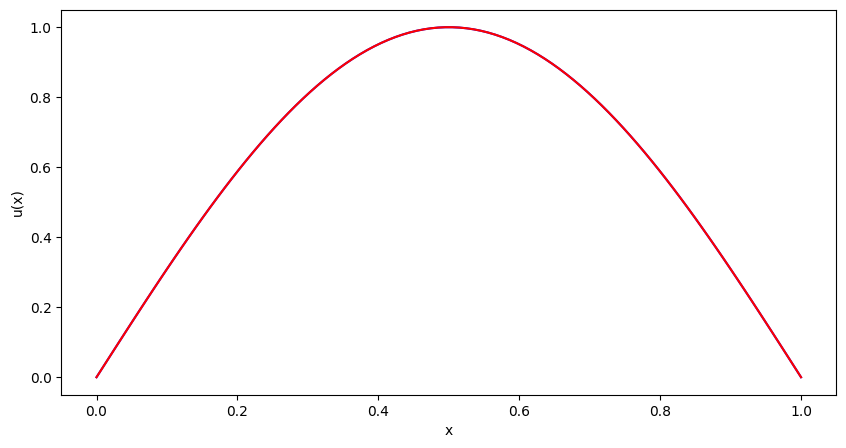

In [ ]:
u_pred = model(x_colloc).detach().cpu()
u_exact = analytical_solution(x_colloc).detach().cpu()

plt.figure(figsize=(10,5))
plt.plot(x_colloc.detach().numpy() , u_pred, label='Predicted' , color = 'blue' , license)
plt.plot(x_colloc.detach().numpy() , u_exact, label='Exact' , color = 'red')
plt.xlabel('x')
plt.ylabel('u(x)')

## Fourier

Text(0.5, 0, 'x')

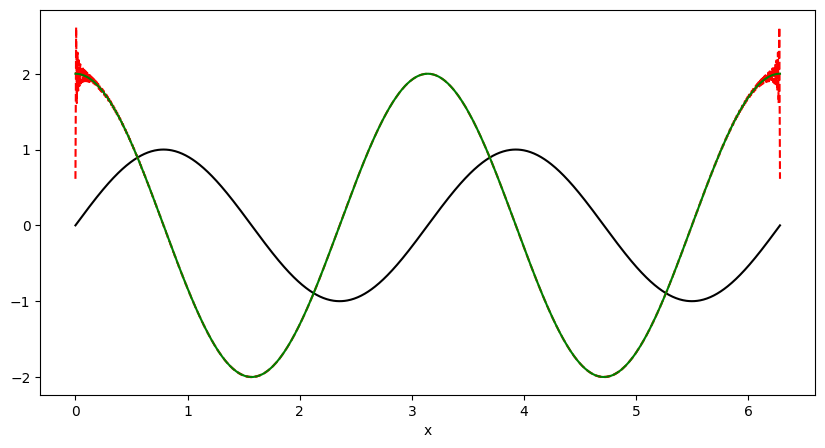

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Sample points
x = np.linspace(0, 2*np.pi, 1024)
f = np.sin(2*x)
dx = x[1] - x[0]
# Compute FFT
f_hat = np.fft.fft(f)
k = np.fft.fftfreq(len(x), d=dx) * 2 * np.pi

# Compute first derivative in Fourier space
f_prime_hat = 1j * k * f_hat

# Inverse FFT to get derivative in spatial domain
f_prime = np.fft.ifft(f_prime_hat).real
f_prime_exact = 2*np.cos(2*x)

plt.figure(figsize=(10,5))
plt.plot(x, f, label='f(x)', color='black')
plt.plot(x, f_prime, label="f'(x)", linestyle='--', color='red')
plt.plot(x, f_prime_exact, label="f'(x) (exact)", color='green')
plt.xlabel('x')

Text(0.5, 0, 'x')

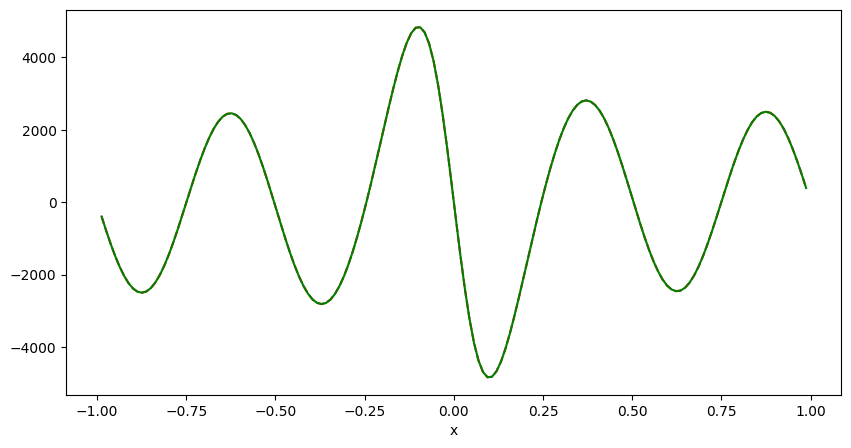

In [149]:
import torch


def fourier_derivative(u, x , order=1):
    # Compute the Fourier derivative of u
    u = u.squeeze()
    x = x.squeeze()
    N = u.size(0)
    u_hat = torch.fft.fft(u)
    dx = x[1] - x[0]
    k = torch.fft.fftfreq(N, d=dx) * 2 * torch.pi
    u_prime_hat = (1j * k)**order * u_hat
    u_prime = torch.fft.ifft(u_prime_hat).real
    return u_prime

# Sample points
x = torch.linspace(-2*torch.pi, 2*torch.pi, 1000)
x = x[1:]
function = lambda x: -(-1.6 * (torch.pi**2) * torch.sin(torch.pi * x * 4) - 50 * torch.tanh(5 * x) * (1 - torch.tanh(5 * x)**2))
f = function(x)
# Compute Fourier derivative
f_prime = fourier_derivative(f, x , order=2)
x.requires_grad = True
f_prime_exact = derivation(function(x), x , order=2)

mask = (x >= -1) & (x <= 1)
x = x[mask]
f = f[mask]
f_prime = f_prime[mask]
f_prime_exact = f_prime_exact[mask]


plt.figure(figsize=(10,5))
#plt.plot(x, f, label='f(x)', color='black')
plt.plot(x.detach().numpy(), f_prime, label="f'(x)", linestyle='--', color='red')
plt.plot(x.detach().numpy(), f_prime_exact.detach().numpy(), label="f'(x) (exact)", color='green')
plt.xlabel('x')

In [ ]:
model = Net(1,1,100,3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

f= lambda x: -(-1.6 * (torch.pi**2) * torch.sin(torch.pi * x * 4) - 50 * torch.tanh(5 * x) * (1 - torch.tanh(5 * x)**2))
u_exact = lambda x :  0.1*torch.sin(torch.pi*x*4) + torch.tanh(5*x)

num_samples = 80

# Define the interval from -π to π
a = -torch.pi
b = torch.pi

x = torch.linspace(a, b, num_samples , requires_grad= True)
#uniform distribution
x = torch.rand(num_samples) * (b - a) + a
x = torch.sort(x)[0]
x.requires_grad = True
print(x[mask].shape)
u_bound1 = u_exact(x[mask][0])
u_bound2 = u_exact(x[mask][-1])

num_epochs = 3000

for epoch in range(1, num_epochs + 1):

    optimizer.zero_grad()
    u = model(x.unsqueeze(1))
    #d2u = operator(u, x)
    #du = derivation(u, x, order=1)
    #derivative_2d = derivation(u, x, order=2)
    source_f = f(x)[mask]

    #fourier_derivative_2 = fourier_derivative(u, x , order=2)[mask]
    normal_derivative_2 = derivation(u, x, order=2)[mask]
    
    
    fourier_loss = F.mse_loss(normal_derivative_2, source_f)
    boundary_loss = (torch.abs(u[mask][0] - u_bound1)**2 + torch.abs(u[mask][-1] - u_bound2)**2)/2

    loss = fourier_loss + 10*boundary_loss

    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 500 == 0 or epoch == 1:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

torch.Size([33])
Epoch 1, Loss: 186.832550
Epoch 500, Loss: 0.156672
Epoch 1000, Loss: 0.017382
Epoch 1500, Loss: 0.013984
Epoch 2000, Loss: 0.003464
Epoch 2500, Loss: 0.001469
Epoch 3000, Loss: 0.008168


tensor(0.0012, grad_fn=<MseLossBackward0>)


Text(0.5, 0, 'x')

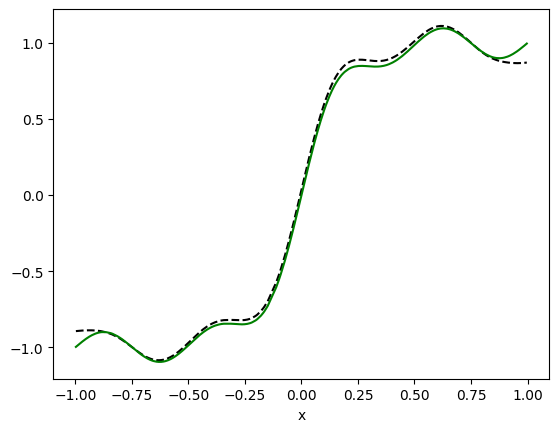

In [183]:
a = -1
b = 1

x = a + (b - a) * torch.rand(500)
x = torch.sort(x).values
u_test = model(x.unsqueeze(1))
u_exact_test = u_exact(x)
print(F.mse_loss(u_test.squeeze(), u_exact_test))

plt.plot(x.detach().numpy(), u_test.detach().numpy(), label='Approximation' , color = 'black' ,linestyle = '--')
plt.plot(x.detach().numpy(), u_exact_test.detach().numpy(), label='Exact' , color = 'green')
plt.xlabel('x')

